# 如何对真实样本分类
《机器学习系统设计》第二章

## Iris数据集
测量的是每个花朵的以下四个属性（4个特征），共150个样本：

- 花萼长度(sepal length)
- 花萼宽度(sepal width)
- 花瓣长度(petal length)
- 花瓣宽度(petal width)

In [1]:
%matplotlib inline

In [3]:
from sklearn.datasets import load_iris

data = load_iris()
features = data.data
features.shape

(150, 4)

In [4]:
feature_names = data.feature_names
feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

需要预测类别：

- 山鸢尾(setosa)
- 变色鸢尾(versicolor)
- 维吉尼亚鸢尾(virginica)

target的值有三个0，1，2表示三分类

- 0代表setosa
- 1代表versicolor
- 2代表virginica

In [5]:
target = data.target # target的值是0，1，2
target.shape

(150,)

In [6]:
target_names = data.target_names
target_names

array(['setosa', 'versicolor', 'virginica'], 
      dtype='|S10')

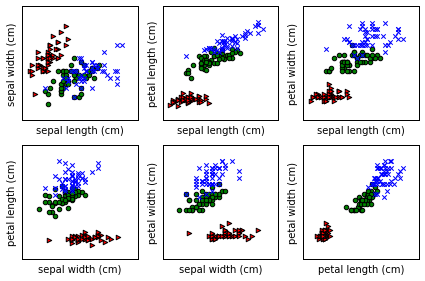

In [7]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(2, 3) #两行三列
pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

# Set up 3 different pairs of (color, marker)
color_markers = [
        ('r', '>'), # setosa
        ('g', 'o'), # versicolor
        ('b', 'x'), # virginica
        ]
for i, (p0, p1) in enumerate(pairs):
    ax = axes.flat[i]

    for t in range(3):
        # Use a different color/marker for each class `t`
        c, marker = color_markers[t]
        ax.scatter(features[target == t, p0], features[target == t, p1], marker=marker, c=c)
    ax.set_xlabel(feature_names[p0])
    ax.set_ylabel(feature_names[p1])
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

## 构建第一个分类模型
观察可视化第2张图：花瓣长度(petal length)可以将setosa和其它两类分开

In [8]:
from sklearn.datasets import load_iris

data = load_iris()
features = data['data'] #shape (150,4)
target = data['target'] #shape (150,)
target_names = data['target_names'] # ['setosa', 'versicolor', 'virginica']
labels = target_names[target] # labels是一个包含（'setosa', 'versicolor', 'virginica'）的数组，shape (150,)
plength = features[:, 2]  # 取出第3列feature即petal length

# To use numpy operations to get setosa features,
# we build a boolean array
is_setosa = (labels == 'setosa') # boolean数据，shape (150,)

max_setosa = plength[is_setosa].max()
min_non_setosa = plength[~is_setosa].min()

print('Maximum of setosa: {0}.'.format(max_setosa))
print('Minimum of others: {0}.'.format(min_non_setosa))

Maximum of setosa: 1.9.
Minimum of others: 3.0.


对所有可能的特征和阈值进行遍历，寻找更高的正确率：

In [20]:
# This function was called ``learn_model`` in the first edition
def fit_model(features, labels):  # labels: boolean array
    """Learn a simple threshold model"""
    best_acc = -1.0
    # Loop over all the features:
    for fi in range(features.shape[1]):  # 4个feature列
        thresh = features[:, fi].copy()  # 把fi这一列feature拷贝出来(第一个冒号代表所有行)
        # test all feature values in order:
        thresh.sort()
        for t in thresh:
            pred = (features[:, fi] > t) #以t作为分类，大于t的为一类，小于t的为另一类

            # Measure the accuracy of this 
            acc = (pred == labels).mean()

            rev_acc = (pred == ~labels).mean()
            if rev_acc > acc:
                acc = rev_acc
                reverse = True
            else:
                reverse = False
            if acc > best_acc:
                best_acc = acc
                best_fi = fi
                best_t = t
                best_reverse = reverse

    # A model is a threshold and an index
    return best_t, best_fi, best_reverse

# This function was called ``apply_model`` in the first edition
def predict(model, features):
    """Apply a learned model"""
    # A model is a pair as returned by fit_model
    t, fi, reverse = model
    if reverse:
        return features[:, fi] <= t
    else:
        return features[:, fi] > t


def accuracy(features, labels, model):
    """Compute the accuracy of the model"""
    preds = predict(model, features)
    return np.mean(preds == labels)

下图两个区域：一个是白色的，另一个被灰色阴影覆盖。白色区域中的任何点代表的都是Iris Virginica，阴影中任何点代表Iris Versicolor。两条虚线代表两个判别边界（阈值）。

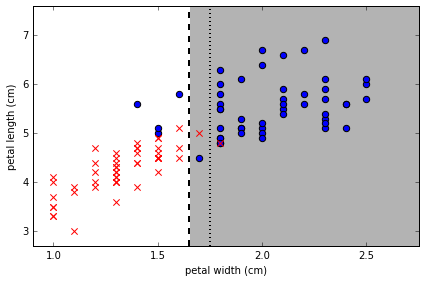

In [18]:
from sklearn.datasets import load_iris
data = load_iris()
features = data.data
feature_names = data.feature_names

target = data.target
target_names = data.target_names

# We use NumPy fancy indexing to get an array of strings:
labels = target_names[target]

is_setosa = (labels == 'setosa')
features = features[~is_setosa]
labels = labels[~is_setosa]
is_virginica = (labels == 'virginica')

# Hand fixed thresholds:
t = 1.65
t2 = 1.75

# Features to use: 3 & 2
f0, f1 = 3, 2

area1c = (1., 1, 1)
area2c = (.7, .7, .7)

# Plot from 90% of smallest value to 110% of largest value
# (all feature values are positive, otherwise this would not work very well)

x0 = features[:, f0].min() * .9
x1 = features[:, f0].max() * 1.1

y0 = features[:, f1].min() * .9
y1 = features[:, f1].max() * 1.1

fig, ax = plt.subplots()
ax.fill_between([t, x1], [y0, y0], [y1, y1], color=area2c)
ax.fill_between([x0, t], [y0, y0], [y1, y1], color=area1c)
ax.plot([t, t], [y0, y1], 'k--', lw=2)
ax.plot([t2, t2], [y0, y1], 'k:', lw=2)
ax.scatter(features[is_virginica, f0], features[is_virginica, f1], c='b', marker='o', s=40)
ax.scatter(features[~is_virginica, f0], features[~is_virginica, f1], c='r', marker='x', s=40)
ax.set_ylim(y0, y1)
ax.set_xlim(x0, x1)
ax.set_xlabel(feature_names[f0])
ax.set_ylabel(feature_names[f1])
fig.tight_layout()

## 评估

In [21]:
import numpy as np
from sklearn.datasets import load_iris

data = load_iris()
features = data['data']  # (150, 4)
labels = data['target_names'][data['target']]  # (150,)

# We are going to remove the setosa examples as they are too easy:
is_setosa = (labels == 'setosa')  # (150,)
features = features[~is_setosa]  # (100, 4) 去掉50个setosa
labels = labels[~is_setosa]  # (100,)
# Now we classify virginica vs non-virginica
is_virginica = (labels == 'virginica')

# Split the data in two: testing and training
testing = np.tile([True, False], 50)  # testing = [True,False,True,False,True,False...]

# Training is the negation of testing: i.e., datapoints not used for testing,
# will be used for training
training = ~testing  # 50个train,50个testing

model = fit_model(features[training], is_virginica[training])
train_accuracy = accuracy(features[training], is_virginica[training], model)
test_accuracy = accuracy(features[testing], is_virginica[testing], model)

print('''\
Training accuracy was {0:.1%}.
Testing accuracy was {1:.1%} (N = {2}).
'''.format(train_accuracy, test_accuracy, testing.sum()))

Training accuracy was 96.0%.
Testing accuracy was 90.0% (N = 50).



# knn分类器
## seed数据集
小麦种子的测量数据，有7个特征：

- 面积(A)
- 周长(P)
- 精密度($4\pi A/P^2$)
- 谷粒的长度
- 谷粒的宽度
- 偏度系数
- 谷粒槽长度

三个品种（3分类）：

- Canadian
- Kama
- Rosa

In [22]:
import numpy as np


def load_dataset(dataset_name):
    """
    data,labels = load_dataset(dataset_name)

    Load a given dataset

    Returns
    -------
    data : numpy ndarray
    labels : list of str
    """
    data = []
    labels = []
    with open('./data/{0}.tsv'.format(dataset_name)) as ifile:
        for line in ifile:
            tokens = line.strip().split('\t')
            data.append([float(tk) for tk in tokens[:-1]])
            labels.append(tokens[-1])
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

## 自己实现的KNN分类器

In [23]:
import numpy as np


# This function was called ``learn_model`` in the first edition
def fit_model(k, features, labels):
    """Learn a k-nn model"""
    # There is no model in k-nn, just a copy of the inputs
    return k, features.copy(), labels.copy()


def plurality(xs):
    """Find the most common element in a collection"""
    from collections import defaultdict
    counts = defaultdict(int)
    for x in xs:
        counts[x] += 1
    maxv = max(counts.values())
    for k, v in counts.items():
        if v == maxv:
            return k  # k是label值,v是计数


# This function was called ``apply_model`` in the first edition
def predict(model, features):
    """Apply k-nn model"""
    k, train_feats, labels = model
    results = []
    for f in features:
        # f 7维向量
        label_dist = []
        # Compute all distances:全局算一遍和所有已知feature和该点的距离
        for t, ell in zip(train_feats, labels):
            # t 7维向量
            # ell 某个label
            label_dist.append((np.linalg.norm(f - t), ell))
        label_dist.sort(key=lambda d_ell: d_ell[0])
        label_dist = label_dist[:k]  # 取前k个离该点最近的点
        results.append(plurality([ell for _, ell in label_dist]))
    return np.array(results)


def accuracy(features, labels, model):
    preds = predict(model, features)
    return np.mean(preds == labels)

在数据集上应用上述算法，进行10折交叉验证，得到89%的正确率。

由于长度，面积和无量纲的量加了起来，把各种单位混合在一起了，把所有特征归一到一个公共尺度上：Z-score，得到94%正确率。

In [26]:
import numpy as np

features, labels = load_dataset('seeds')
# features.shape  # (210, 7) 7个feature
# len(features)  # 210
# labels.shape  # (210,)三分类分别是Kama,Rosa,Canadian


def cross_validate(features, labels):
    """Compute cross-validation errors"""
    error = 0.0
    for fold in range(10):
        training = np.ones(len(features), bool)
        training[fold::10] = 0 # [a:b:c] a-start,b-end,c-step length
        testing = ~training
        model = fit_model(1, features[training], labels[training])
        test_error = accuracy(features[testing], labels[testing], model)
        error += test_error

    return error / 10.0

error = cross_validate(features, labels)
print('Ten fold cross-validated error was {0:.1%}.'.format(error))

# Z-score (whiten) the features
features -= features.mean(0)
# features.mean(0).shape  # (7,)即7个feature分别的平均值
features /= features.std(0)
# features.std(0).shape  # (7,)
error = cross_validate(features, labels)
print('Ten fold cross-validated error after z-scoring was {0:.1%}.'.format(error))

Ten fold cross-validated error was 89.5%.
Ten fold cross-validated error after z-scoring was 94.3%.


## sklearn KNN

In [28]:
from __future__ import print_function
import numpy as np


# Import sklearn implementation of KNN
from sklearn.neighbors import KNeighborsClassifier

features, labels = load_dataset('seeds')
classifier = KNeighborsClassifier(n_neighbors=4)
# features.shape  # (210, 7) 7个feature
# labels.shape  # (210,)三分类分别是Kama,Rosa,Canadian

n = len(features)  # 210

correct = 0.0
for ei in range(n):
    training = np.ones(n, bool)
    training[ei] = 0  # [False True ... True] 209个True
    testing = ~training  # [True False ... False] 209个False
    classifier.fit(features[training], labels[training])
    pred = classifier.predict(features[ei].reshape(1, -1))
    # DeprecationWarning: Passing 1d arrays as data is deprecated.
    # Reshape your data either using X.reshape(-1, 1) if your data has a single feature
    # or X.reshape(1, -1) if it contains a single sample.

print('Result of leave-one-out: {}'.format(correct/n))

# Import KFold object
from sklearn.cross_validation import KFold

# means will hold the mean for each fold
means = []

# kf is a generator of pairs (training,testing) so that each iteration
# implements a separate fold.
kf = KFold(len(features), n_folds=3, shuffle=True)
for training, testing in kf:
    # We learn a model for this fold with `fit` and then apply it to the
    # testing data with `predict`:
    classifier.fit(features[training], labels[training])
    prediction = classifier.predict(features[testing])

    # np.mean on an array of booleans returns the fraction of correct decisions
    # for this fold:
    curmean = np.mean(prediction == labels[testing])
    means.append(curmean)
print('Result of cross-validation using KFold: {}'.format(means))

# The function cross_val_score does the same thing as the loop above with a
# single function call

from sklearn.cross_validation import cross_val_score
crossed = cross_val_score(classifier, features, labels)
print('Result of cross-validation using cross_val_score: {}'.format(crossed))

# The results above use the features as is, which we learned was not optimal
# except if the features happen to all be in the same scale. We can pre-scale
# the features as explained in the main text:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
classifier = Pipeline([('norm', StandardScaler()), ('knn', classifier)])
crossed = cross_val_score(classifier, features, labels)
print('Result with prescaling: {}'.format(crossed))


# Now, generate & print a cross-validated confusion matrix for the same result
from sklearn.metrics import confusion_matrix
names = list(set(labels))  # ['Kama', 'Rosa', 'Canadian']
labels = np.array([names.index(ell) for ell in labels])  # [0 0 ... 0 1 1 ... 1 2 2 ... 2]
preds = labels.copy()
preds[:] = -1  # 数组元素全部置成-1
for train, test in kf:
    classifier.fit(features[train], labels[train])
    preds[test] = classifier.predict(features[test])

cmat = confusion_matrix(labels, preds)
print()
print('Confusion matrix: [rows represent true outcome, columns predicted outcome]')
print(cmat)

# [[62  2  6] # 类1的70个样本有2个错分为类2,6个错分为类3
#  [ 4 66  0]
#  [ 5  0 65]]

# The explicit float() conversion is necessary in Python 2
# (Otherwise, result is rounded to 0)
acc = cmat.trace()/float(cmat.sum())
print('Accuracy: {0:.1%}'.format(acc))

Result of leave-one-out: 0.0
Result of cross-validation using KFold: [0.91428571428571426, 0.87142857142857144, 0.87142857142857144]
Result of cross-validation using cross_val_score: [ 0.94444444  0.86956522  0.82608696]
Result with prescaling: [ 0.94444444  0.92753623  0.84057971]

Confusion matrix: [rows represent true outcome, columns predicted outcome]
[[65  1  4]
 [ 4 66  0]
 [ 5  0 65]]
Accuracy: 93.3%


## 调优knn中的k

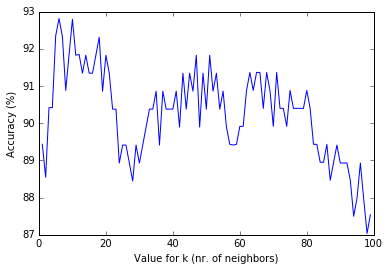

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


features, labels = load_dataset('seeds')
# features.shape  # (210, 7) 7个feature
# len(features)  # 210
# labels.shape  # (210,)三分类分别是Kama,Rosa,Canadian

# Values of k to consider: all in 1 .. 160
ks = np.arange(1, 100)

# We build a classifier object here with the default number of neighbors
# (It happens to be 5, but it does not matter as we will be changing it below
classifier = KNeighborsClassifier()
classifier = Pipeline([('norm', StandardScaler()), ('knn', classifier)])

# accuracies will hold our results
accuracies = []
for k in ks:
    # set the classifier parameter
    classifier.set_params(knn__n_neighbors=k)
    crossed = cross_val_score(classifier, features, labels)

    # Save only the average
    accuracies.append(crossed.mean())

accuracies = np.array(accuracies)

# Scale the accuracies by 100 to plot as a percentage instead of as a fraction
plt.plot(ks, accuracies*100)
plt.xlabel('Value for k (nr. of neighbors)')
plt.ylabel('Accuracy (%)')